## <font style='font-size: 30px;'> Avaliação do modelo de primeira ordem </font> <hr style='line: 2px solid;'>

A função de transferência média da planta de nível 1 é dada por:

$$ \frac{K}{\tau s+1} = \frac{0.9}{63s+1} → \frac{0.9/63}{s+1/63} $$

Essa é uma função de primeira ordem que possui um erro no estado estacionário de 0.9 (basta fazer s→0), como podemos ver:


                  planta de nível 1 Fechada
RiseTime                           71.7217
SettlingTime                      131.8753
SettlingMin                         0.4263
SettlingMax                         0.4737
Overshoot                           0.0000
Undershoot                          0.0000
Peak                                0.4732
PeakTime                          229.0466
SteadyStateValue                    0.4737
Erro(%)                             0.5263


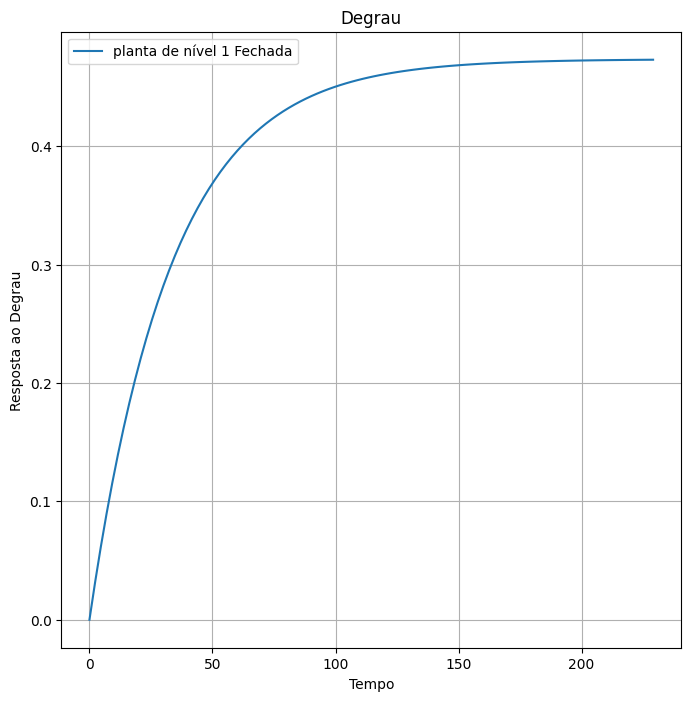

In [96]:
planta_nivel_1 = ct.TransferFunction([0.9/63],[1,1/63])
planta_nivel_1_fechada = ct.feedback(planta_nivel_1, 1)
parametros = obter_plot_degrau({'planta de nível 1 Fechada':planta_nivel_1_fechada}, amortecimento=0.02)
parametros

Nesse contexto, os parâmetros que podemos tentar melhorar são:

- tempo de estabilização e
- erro no regime estacionário.

Um controlador PI pode nos ajudar a zerar o erro em regime permanente e melhorar o tempo de acomodação. Para iniciar o projeto, vou definir os seguintes requisitos:

- $e_{ss} = 0$;
- $T_s = 100$

O procedimento pelo lugar das raizes consiste no seguinte:

<font style='font-size: 20px;'> 1. Defina qual é o seu par complexo conjugado para produzir suas especificações </font> <hr style='line: 2px solid;'>

In [123]:
s = obter_conjulgados_dominantes(Mp=0.01, Ts=100)
print(s[0])

(-0.04+0.027j)


<font style='font-size: 20px;'> 2. Posicione um polo na origem e calcule a defaseagem angular a ser compensada </font> <hr style='line: 2px solid;'>

A função abaixo fará exatamente isso. Ela pega um sistema G(s) — dado em uma lista de coeficientes $den$ e $num$ — e um polo complexo do par de polos complexos conjugados desejado. A função calcula a o angulo de cada polo e calcula a defasagem.

In [98]:
obter_defasagem_angular([0.9/63],[1,1/63], s[0])

1° Polo faz 131.78 com o S
2° Polo faz 145.98 com o S
 
 Zero precisa somar: 97.8


<font style='font-size: 20px;'> 3. Defina um zero e um ganho para obter seu controlador </font> <hr style='line: 2px solid;'>

Agora, para o mesmo sistema, com o mesmo polo complexo, utilizamos a função 'obter_controlador_pi' que irá retorar o controlador PI necessário para compensar o angulo necessário. Printará a posição do zero, $\frac{k_2}{k_1}$, além de vários parâmetros, incluindo as próprias expressões do controlador e malha aberta.

In [115]:
obter_controlador_pi(num=[0.9/63], den=[1, 1/63], s=s[0], phi_z=97.8, phi_p=146)


 1/ti : 0.0363

 k: 4.488752192780162

 O ganho do controlador deve ser : 4.4888

 Seu controlador é : 
 
4.489 s + 0.163
---------------
       s


 Sua malha sem controlador é : 
 
  0.01429
-----------
s + 0.01587


 Sua malha com controlador é : 
 
0.06413 s + 0.002329
--------------------
  s^2 + 0.01587 s



<font style='font-size: 20px;'> 4. Verifique o lugar das raízes </font> <hr style='line: 2px solid;'>

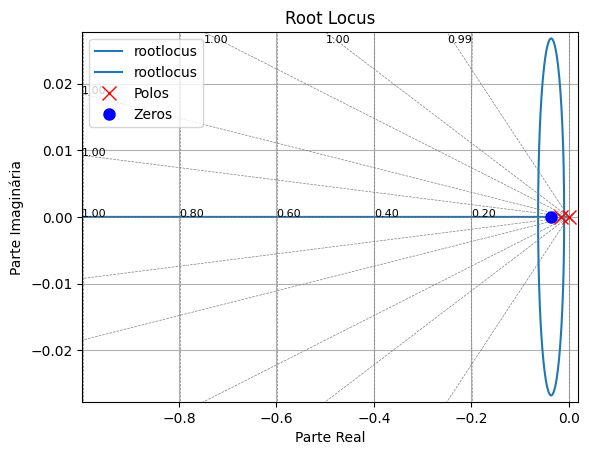


 Polos : 
-0.0159+0.0000j
0.0000+0.0000j

 Zeros : 
-0.0359+0.0000j


In [116]:
obter_lugar_raizes([0.0641, 0.0023], [1, 0.0159, 0])

<font style='font-size: 20px;'> 5. Simule a resposta ao degrau </font> <hr style='line: 2px solid;'>


                  Malha fechada
RiseTime               22.6770
SettlingTime          104.6630
SettlingMin             0.9059
SettlingMax             1.0877
Overshoot               8.7651
Undershoot              0.0000
Peak                    1.0877
PeakTime               54.0759
SteadyStateValue        1.0000
Erro(%)                 0.0000


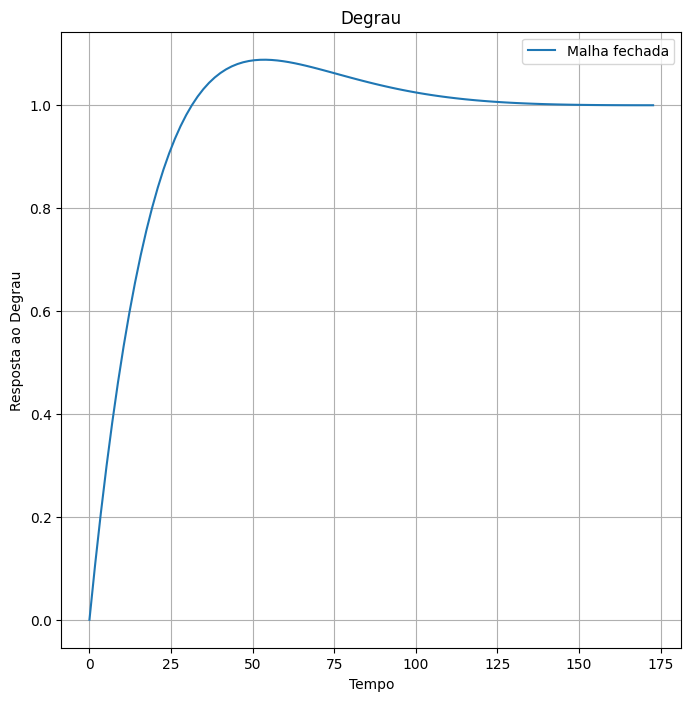

In [117]:
# Construção dos objetos 'TransferFunction'
malha_aberta = ct.TransferFunction([0.0641, 0.0023], [1, 0.0159, 0])
malha_fechada = ct.feedback(malha_aberta, 1)

# # Plot da resposta ao degrau
obter_plot_degrau({"Malha fechada":malha_fechada})



## <font style='font-size: 30px;'> Funções </font> <hr style='line: 2px solid;'>

In [114]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.signal as signal
import numpy as np
import pandas as pd
import control as ct
import scipy as sp
import warnings
import cmath


def obter_conjulgados_dominantes(Mp, Ts):
    xi = -np.log(Mp) / np.sqrt(np.pi**2 + np.log(Mp)**2)
    wn = 4 / (Ts * xi)
    wd = wn * np.sqrt(1 - xi**2)
    pole1 = complex(-xi*wn, wd)
    pole2 = complex(-xi*wn, -wd)
    pole1 = np.round(pole1, decimals=3)  # Arredondar o polo1 para 3 casas decimais
    pole2 = np.round(pole2, decimals=3)  # Arredondar o polo2 para 3 casas decimais
    return [pole1, pole2]


def obter_defasagem_angular(num, den, s):

    # Obter os polos e zeros da função de transferência
    polos = np.roots(den)
    zeros = np.roots(num)
    
    # Adicionar um polo na origem
    polos = np.append(polos, 0)

    # Calcular a defasagem angular
    phi = np.pi
    
    # Calcular contribuição dos polos
    i = 1
    for polo in polos:
        angulo = np.angle(s - polo)
        print(f"{i}° Polo faz {angulo*(180/np.pi):.2f} com o S")
        phi -= angulo
        i += 1
    
    # Calcular contribuição dos zeros
    i = 1
    for zero in zeros:
        angulo = np.angle(s - zero)
        print(f"{i}° Zero faz {angulo*(180/np.pi):.2f} com o S")
        phi += angulo
        i += 1

    # # → LOG
    # print(f"\n LOG: soma dos angulos {phi*(180/np.pi):.2f} ")

    # # Reduzir phi ao intervalo de 0 a 180 graus
    # while phi < 0:
    #     phi += np.pi
    
    # while phi > np.pi:
    #     phi -= np.pi
        
    print(f" \n Zero precisa somar: {round(-phi*180/np.pi,1)}")


def obter_controlador_pi(num, den, s, phi_z, phi_p):

    # Paramentros para z_pi
    hip = np.sqrt(s.real**2 + s.imag**2) # → hipotenusa do triangulo retangulo formado pelo ponto +s
    ang_p = 180 - phi_p # → angulo interno formado pelo triangulo ZPS (angulo de P)
    ang_s = 180 - phi_z -ang_p # → angulo interno formado pelo triangulo ZSP (angulo de S)


    # Lei de senos para encontrar posição do zero (zero de PI)
    z_pi = hip * np.sin(ang_s*np.pi/180) / np.sin(phi_z*np.pi/180)
    print(f"\n 1/ti : {z_pi:.4f}")

    # valorando a função transferência para s
    den_eval = np.polyval(den, s)
    den_eval = np.abs(den_eval)
    num_eval = np.polyval(num, s)
    num_eval = np.abs(num_eval)
    
    # valorando o contorlador PI para s
    den_eval_pi = np.abs(s)
    num_eval_pi = np.abs(s + z_pi)

    # Cálculo do valor de k
    k = (den_eval * den_eval_pi)/(num_eval * num_eval_pi)
    print("\n k:",k)
    
    print(f"\n O ganho do controlador deve ser : {k:.4f}")
    
    # Construção da função de transferência do controlador PI
    C_pi = ct.TransferFunction([k, k*z_pi], [1,0])
    G = ct.TransferFunction(num, den)
    C_pi_G = C_pi * G
    
    # Imprimir a função de transferência do controlador PI
    print(f"\n Seu controlador é : \n {C_pi}")
    print(f"\n Sua malha sem controlador é : \n {G}")
    print(f"\n Sua malha com controlador é : \n {C_pi_G}")


def obter_lugar_raizes(num, den):
    
    system = ct.TransferFunction(num, den)
    poles, zeros = ct.pzmap(system, plot=False)
    
    if len(poles) == 0:
        print("Não há polos no sistema.")
        return

    fig, ax = plt.subplots()

    # rlist, klist = ct.root_locus(system, plot=False)
    rlist, klist = ct.root_locus(system, plot=True, ax=ax)

    ax.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Polos')
    ax.plot(np.real(zeros), np.imag(zeros), 'bo', markersize=8, label='Zeros')

    plt.legend()
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.grid(True)
    plt.show()

    print("\n Polos : ")
    for polo in poles:
        print(f"{polo:.4f}")
    
    print("\n Zeros : ")
    for zero in zeros:
        print(f"{zero:.4f}")

    #print("\n Ganho crítico (ganho no ponto de ruptura):", np.abs(klist[-1]))


def obter_plot_degrau(transfer_functions, amortecimento=0.02):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
        # obter resposta ao degrau unitário
        tempo, resposta = ct.step_response(transfer_function)
        ax.plot(tempo, resposta, label=name)

        # obter informações
        info_sistema = ct.step_info(transfer_function, SettlingTimeThreshold=amortecimento)
        df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=[name])
        df_sistema.index.name = 'Parâmetro'

        # Adicionar erro
        e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', name])}")
        df_adicional = pd.DataFrame({name: [e_ss_atual]}, index=['Erro(%)'])
        df_sistema = pd.concat([df_sistema, df_adicional])
        
        # arredondar para 4 decimais
        df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
        print(f"\n {df_sistema}")

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Resposta ao Degrau')
    ax.set_title('Degrau')
    ax.grid(True)
    ax.legend()

    # plt.tight_layout()
    plt.show()

